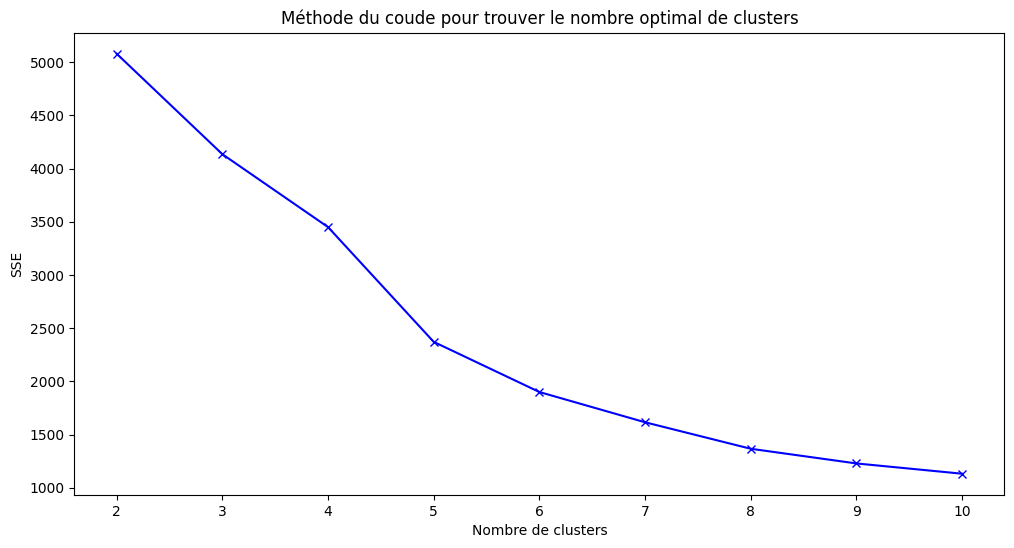

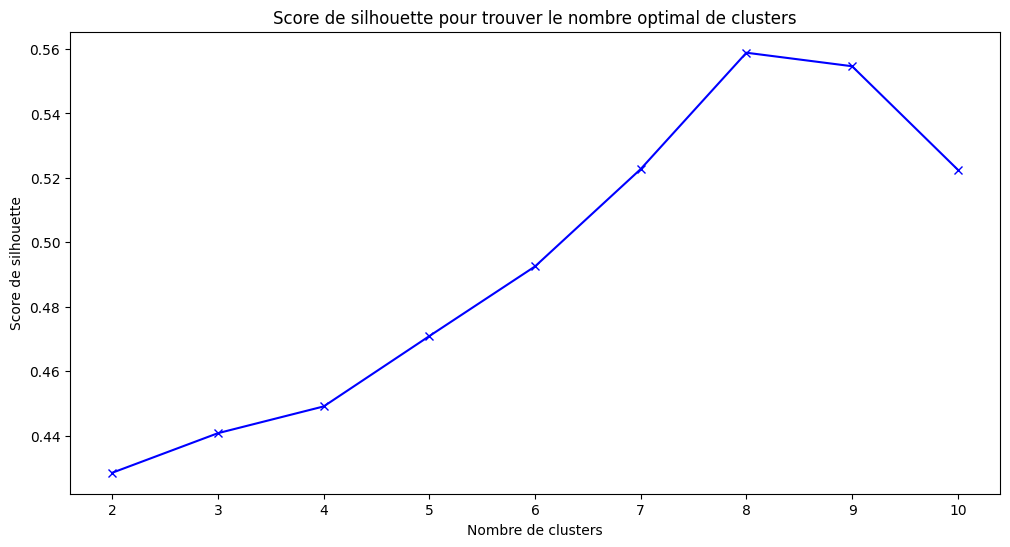

C:\Users\user\AppData\Local\Temp\ipykernel_15320\850304643.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clients['nomcli'], y=top_clients['montant_total_rapatrie'], ax=ax, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_15320\850304643.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clients['nomcli'], y=top_clients['montant_total_rapatrie'], ax=ax, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_15320\850304643.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clients['nomcli'], y=

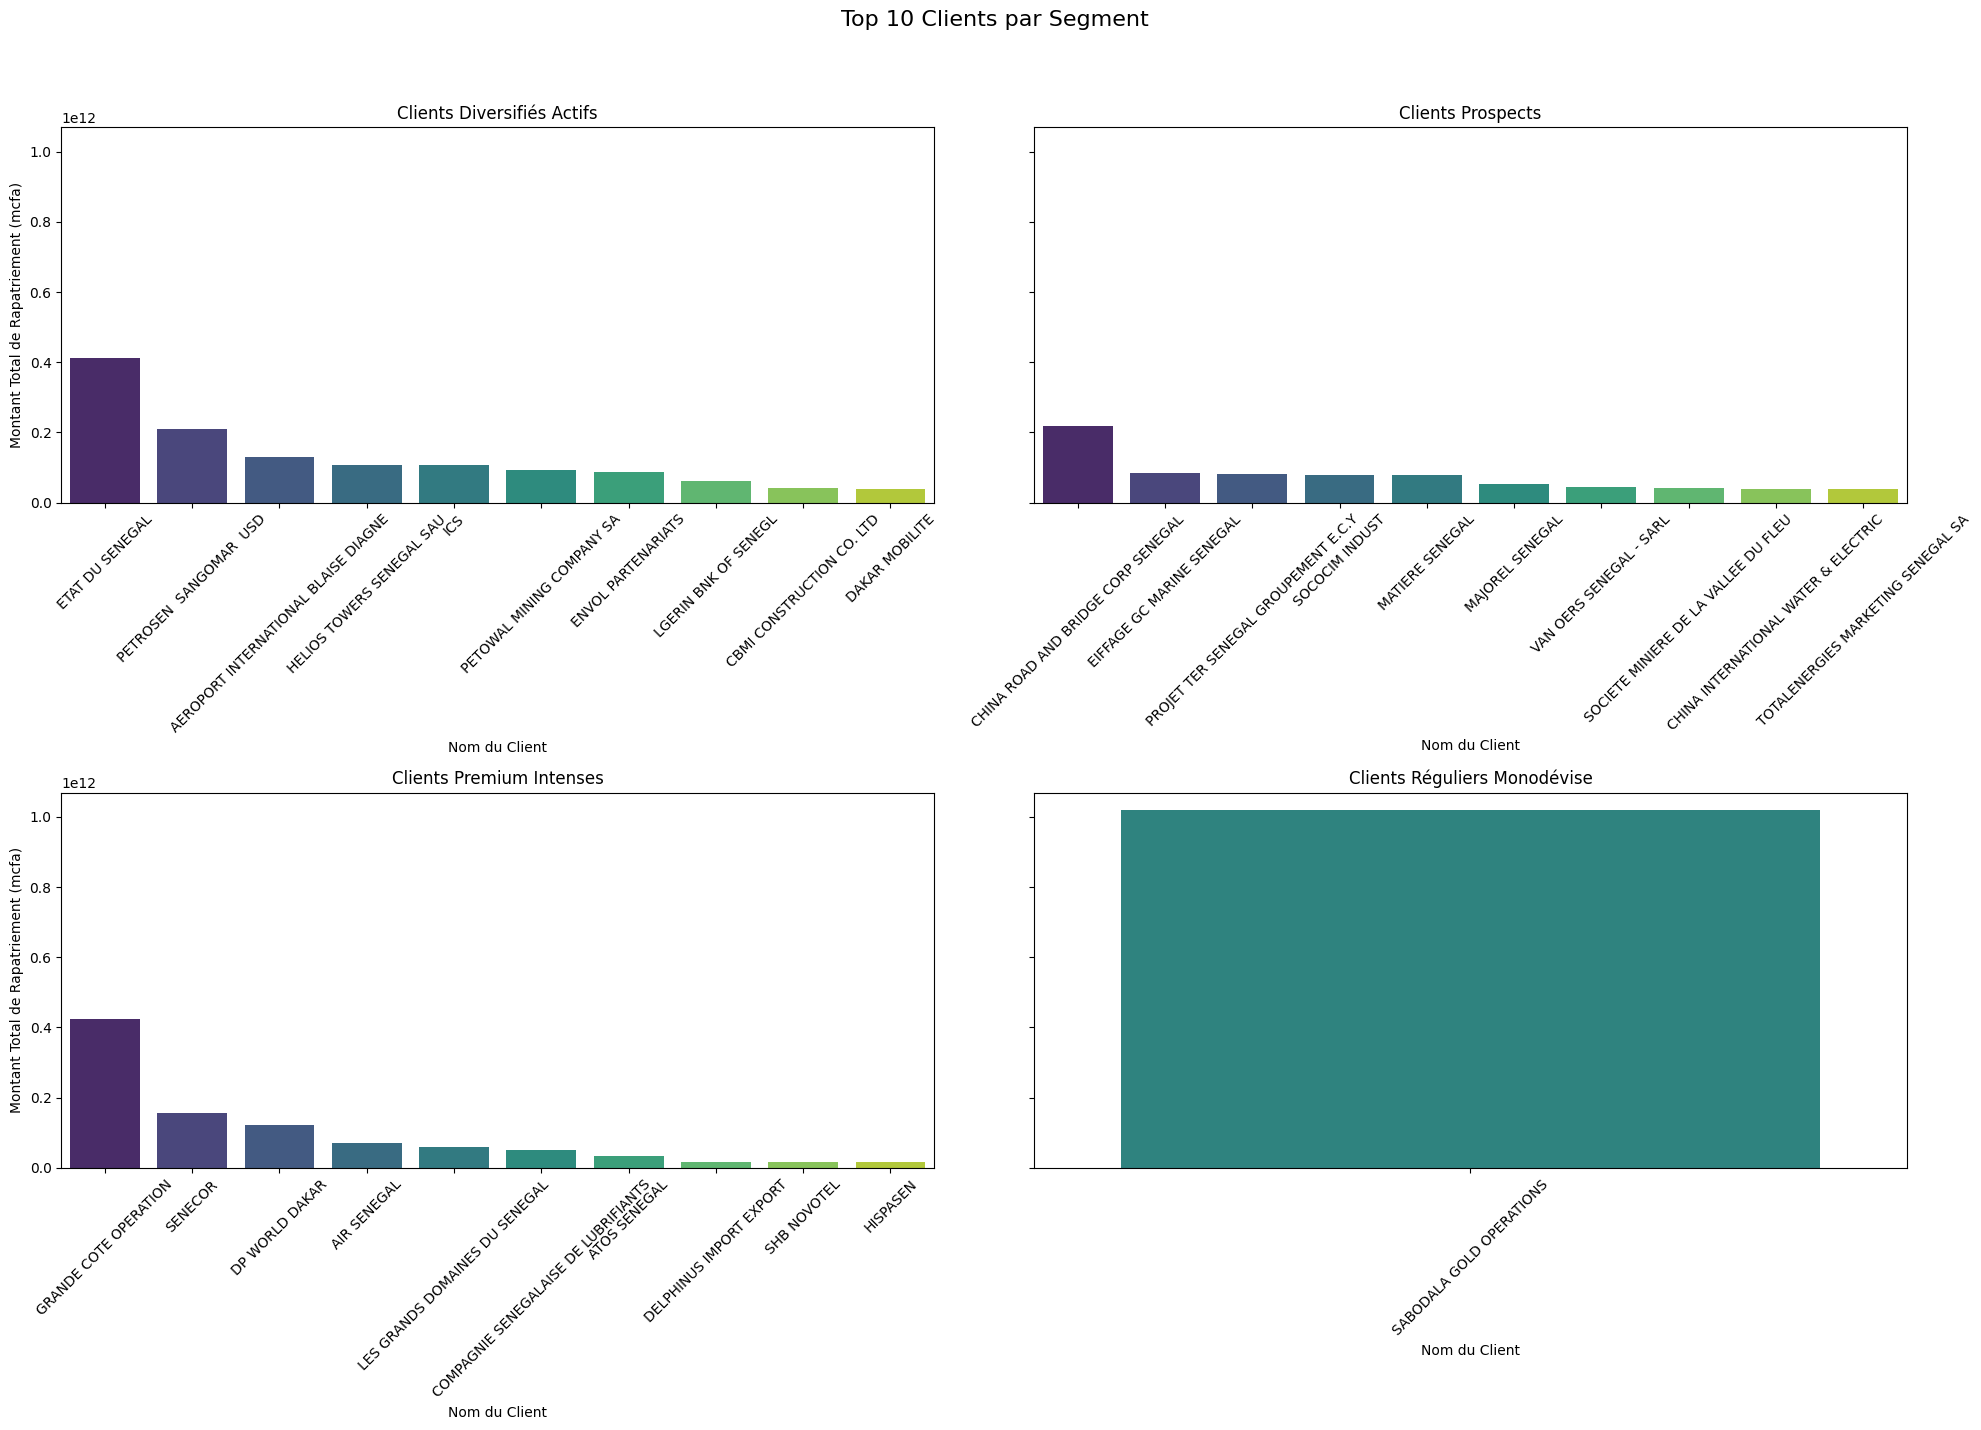

                              montant_total_rapatrie  montant_moyen_rapatrie  \
Segment                                                                        
Clients Diversifiés Actifs              2.288357e+09            2.152163e+08   
Clients Premium Intenses                4.457238e+10            1.015252e+08   
Clients Prospects                       3.293687e+09            8.343594e+07   
Clients Réguliers Monodévise            1.018421e+12            2.624795e+09   

                              nombre_devises_distinctes  \
Segment                                                   
Clients Diversifiés Actifs                     1.080107   
Clients Premium Intenses                       2.217391   
Clients Prospects                              1.731123   
Clients Réguliers Monodévise                   3.000000   

                              frequence_transactions  annee_active  Cluster  \
Segment                                                                       
Client

: 

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
file_path = 'Raptriement_new.csv'
data = pd.read_csv(file_path, sep=';')

# Conversion de la colonne 'dou' en format date
data['dou'] = pd.to_datetime(data['dou'], format='%d/%m/%Y')

# Calculer les caractéristiques pour chaque client
client_features = data.groupby('nomcli').agg(
    montant_total_rapatrie=pd.NamedAgg(column=' mcfa', aggfunc='sum'),
    montant_moyen_rapatrie=pd.NamedAgg(column=' mcfa', aggfunc='mean'),
    nombre_devises_distinctes=pd.NamedAgg(column='dev', aggfunc='nunique'),
    frequence_transactions=pd.NamedAgg(column=' mcfa', aggfunc='count'),
    annee_active=pd.NamedAgg(column='dou', aggfunc=lambda x: x.dt.year.nunique())
).reset_index()

# Standardisation des données
scaler = StandardScaler()
client_features_scaled = scaler.fit_transform(client_features.drop('nomcli', axis=1))

# Trouver le nombre optimal de clusters en utilisant la méthode du coude et le score de silhouette
sse = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(client_features_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(client_features_scaled, kmeans.labels_))

# Tracer la méthode du coude
plt.figure(figsize=(12, 6))
plt.plot(K, sse, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('SSE')
plt.title('Méthode du coude pour trouver le nombre optimal de clusters')
plt.show()

# Tracer le score de silhouette
plt.figure(figsize=(12, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour trouver le nombre optimal de clusters')
plt.show()

# Choisir le nombre optimal de clusters (par exemple, 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(client_features_scaled)

# Ajouter les clusters aux données originales
client_features['Cluster'] = clusters

# Nommer les segments et remplacer "Clients Ponctuels Restreints" par "Clients Prospects"
segment_names = {
    0: "Clients Diversifiés Actifs",  # Clients avec des montants élevés, fréquence de transactions élevée, utilisation de plusieurs devises, actifs sur plusieurs années.
    1: "Clients Prospects",  # Clients avec des montants moyens, faible fréquence de transactions, utilisation de peu de devises, actifs sur une courte durée.
    2: "Clients Premium Intenses",  # Clients avec des montants extrêmement élevés, fréquence de transactions élevée, utilisation de plusieurs devises, actifs sur plusieurs années mais peu nombreux.
    3: "Clients Réguliers Monodévise"  # Clients avec des montants élevés, fréquence de transactions modérée, utilisation d'une seule devise, actifs sur plusieurs années.
}
client_features['Segment'] = client_features['Cluster'].map(segment_names)

# Identifier les top 10 clients de chaque segment
top_clients_per_segment = {}
for segment in segment_names.values():
    top_clients = client_features[client_features['Segment'] == segment].nlargest(10, 'montant_total_rapatrie')
    top_clients_per_segment[segment] = top_clients

# Créer une figure avec plusieurs sous-graphiques pour visualiser les top 10 clients de chaque segment
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)
fig.suptitle('Top 10 Clients par Segment', fontsize=16)

# Tracer des graphiques en barres pour chaque segment
for ax, (segment, top_clients) in zip(axes.flatten(), top_clients_per_segment.items()):
    sns.barplot(x=top_clients['nomcli'], y=top_clients['montant_total_rapatrie'], ax=ax, palette='viridis')
    ax.set_title(segment)
    ax.set_xlabel('Nom du Client')
    ax.set_ylabel('Montant Total de Rapatriement (mcfa)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Analyse des segments en filtrant uniquement les colonnes numériques
numeric_columns = client_features.select_dtypes(include=['number']).columns
segment_analysis = client_features.groupby('Segment')[numeric_columns].mean()
segment_counts = client_features['Segment'].value_counts()
segment_analysis['nombre_de_clients'] = segment_counts

# Afficher l'analyse des segments
print(segment_analysis)
